In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy import stats, integrate
import os

In [2]:
path = '/home/investigator/mariandbt/python/data/'
# path = path + '20230202/'
path = path + '20230207/'

# filename = os.path.join(path, 'pmts_fibers_dig2-192.168.0.254-03.txt')
filename = os.path.join(path, 'pmts_no_fibers_dig2-192.168.0.254-09.txt')

data = []
with open(filename,'r', encoding='ascii') as fp:
    for i, line in enumerate(fp):
#         if i<6:
#             print(line)
#             print(any(c.isalpha() for c in line))

        """
         any(c.isalpha() for c in line) returns True if there's ANY letter from a-z, A-Z in line
         so by doing == False we save ONLY the lines that have NO LETTERS in them
        """;
        if any(c.isalpha() for c in line) == False:
            data.append(np.asarray(line.split('\t')[:-1], dtype=float))
fp.close()

waveform = np.array(data)

In [3]:
n_points = int(waveform[:, 0].max() + 1)
n_frames = int(len(waveform)/n_points) 
print('n_frames = ', n_frames)
print('n_points = ', n_points)
# waveform[:, 0].max()
# np.shape(waveform), len(waveform)

n_frames =  11497
n_points =  252


NOTE: the way the data is stored when using only ONE FILE is the following:
- column 0 is just an index (x-axis if you  will), while columns 1, 2, 3 correspond to data from different channels
- each column stores data from MULTIPLE FRAMES
- each frame has 312 points, so in column 0 you can see how after 311 it resets to 0 when the frame changes

## Waveform

frame =  5748


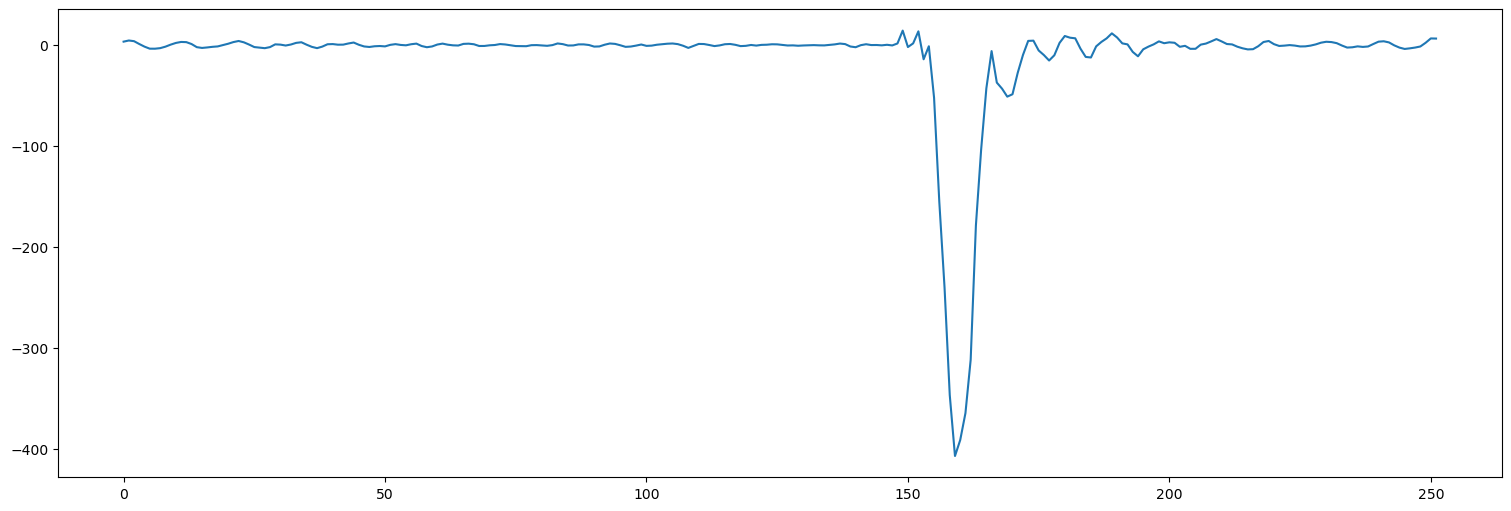

In [4]:
fig, ax = plt.subplots(1, 1, figsize = (15, 5), constrained_layout=True)

"""
ch = 1: DAQ
ch = 2: SiPM/PMT signal
ch = 3: PMT

fib = 0: NO
fib = 1: YES
"""
detect = ['index', 'DAQ', 'SiPM', 'control PMT']
detect = ['index', 'DAQ', 'PMT', 'control PMT']

fibers = [' without fibers', ' with fibers']

ch = 2; fib = 0


frame = int(n_frames/2); print('frame = ', frame)

wave = waveform[frame*n_points: (frame + 1)*n_points].copy()
x_ax = wave[:, 0]

ax.plot(x_ax, wave[:, ch], label = detect[ch])

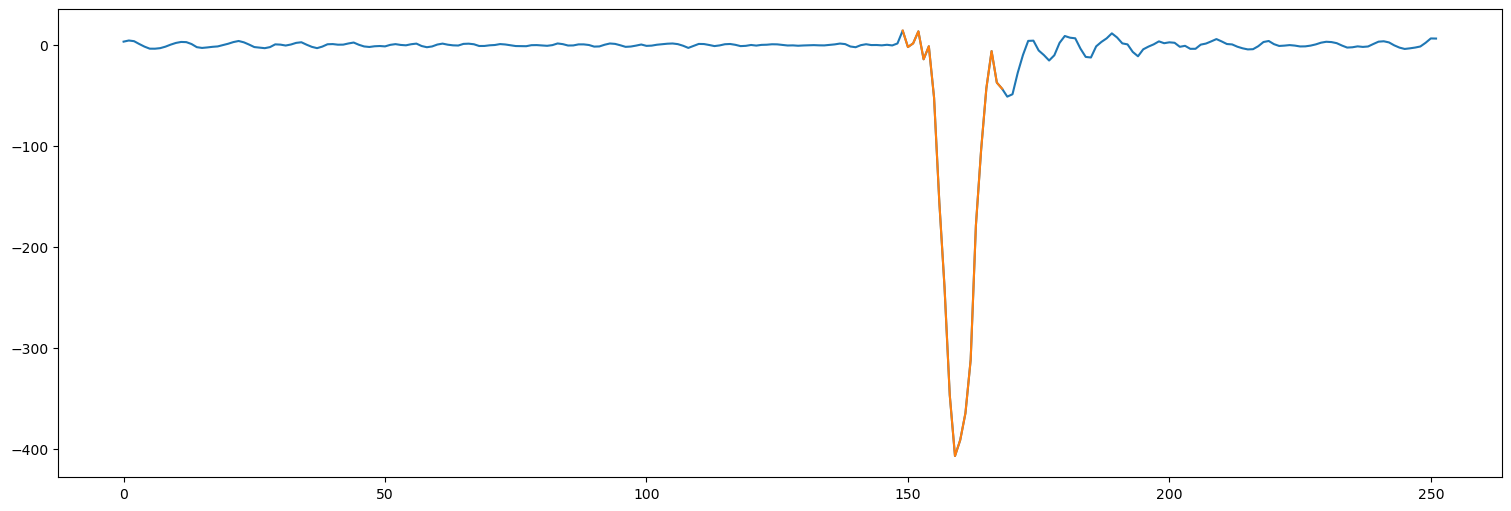

In [9]:
fig, ax = plt.subplots(1, 1, figsize = (15, 5), constrained_layout=True)

t1 = 150
t2 = 200
# t1 = 0
# t2 = 1000

dt_izq = 10
dt_dch = 10

t0 = t1 + int(np.where(wave[:, ch][t1 : t2] == wave[:, ch][t1 : t2].min())[0][0])
peak = wave[:, ch][t0 - dt_izq : t0 + dt_dch].copy()
x_ax_peak = x_ax[t0 - dt_izq : t0 + dt_dch].copy()

ax.plot(x_ax, wave[:, ch], label = detect[ch])
ax.plot(x_ax_peak, peak, label='signal')

## Baseline substraction

#### Baseline mean determination for 1 frame

wave =  252 13.6721 -401.312 -11.492949757539684
baseline =  -1.4593327041382114


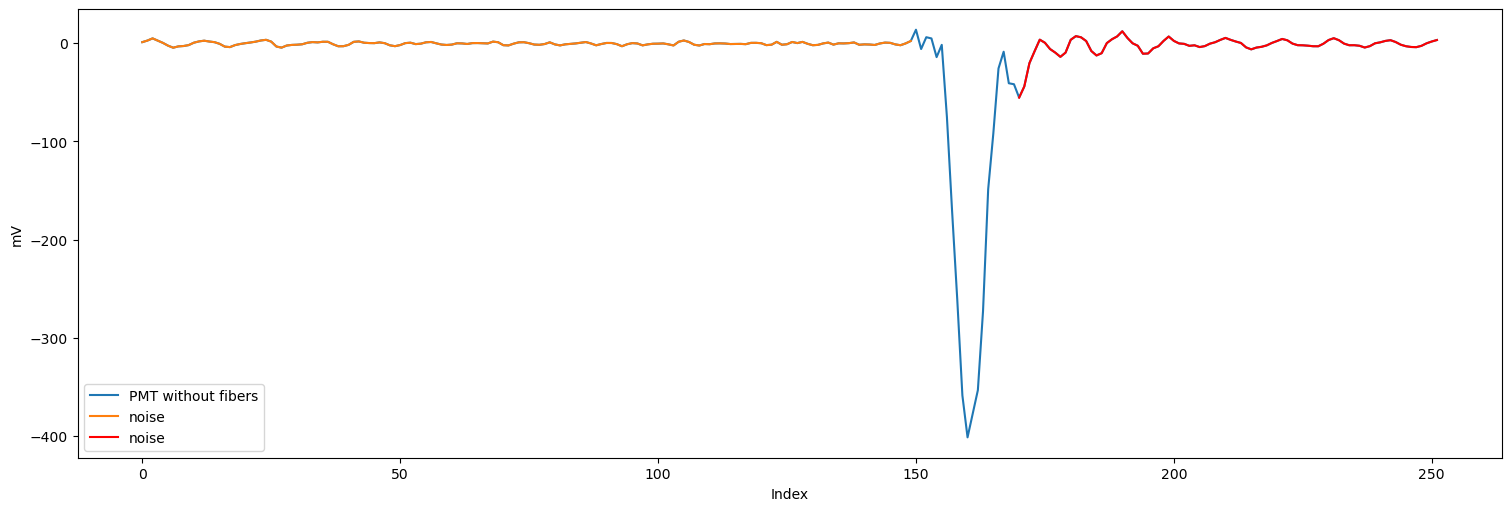

In [10]:
fig, ax = plt.subplots(1, 1, figsize = (15, 5), constrained_layout=True)

frame = 563

wave = waveform[frame*n_points: (frame + 1)*n_points].copy()
print('wave = ', len(wave[:, ch]), wave[:, ch].max(), wave[:, ch].min(), wave[:, ch].mean())

x_ax = wave[:, 0]
# x_ax = np.arange(len(wave))
# ax.plot(x_ax, -6*np.ones(len(x_ax)))

# ax.plot(x_ax, wave[:, 1], label = 'DAQ')
# ax.plot(x_ax, wave[:, 2], label = 'SiPM')
# ax.plot(x_ax, wave[:, 3], label = 'Control PMT')
ax.plot(x_ax, wave[:, ch], label = detect[ch] + fibers[fib])

base = []

t0 = t1 + int(np.where(wave[:, ch][t1 : t2] == wave[:, ch][t1 : t2].min())[0][0])
# t0 = int(np.where(wave[:, ch] == wave[:, ch].min())[0][0])

pre_base = wave[:, ch][:t0 - dt_izq]
x_ax_pre = x_ax[:t0 - dt_izq]

post_base = wave[:, ch][t0 + dt_dch:]
x_ax_post = x_ax[t0 + dt_dch:]

base.append(pre_base.mean())
base.append(post_base.mean())

ax.plot(x_ax_pre, pre_base, label = 'noise')
ax.plot(x_ax_post, post_base, '-r', label = 'noise')



baseline = np.array(base).mean()
print('baseline = ', baseline)

wave[:, ch] = wave[:, ch] - baseline
# ax.plot(x_ax, wave, label = 'Leire\'s PMT corrected by baseline')

#_____________________________________plot settings______________________________________________________________

ax.set_ylabel('mV')
ax.set_xlabel('Index')
# ax.set_title('LED pulse at 1.47V, 2us, 5%df')
# ax.text(0., -200., 'LED at 992mV', #transform=ax.transAxes,
#             fontsize=15, verticalalignment='top', fontfamily='serif',
#             bbox=dict(facecolor='1.', edgecolor='none', pad=3.0))
ax.legend(loc = 'best')


## Peaks integral with baseline substracted

NOTE: dt_dch is not always the same when taking the signal as when substracting the baseline, since there can be part of the waveform that is not signal neither baseline (like the rebound after the signal in the SiPM). That's why we re-define it after the baseline

### 1 frame

base =  [-0.4917706818791946, -2.592929722891566]
baseline =  -1.5423502023853803


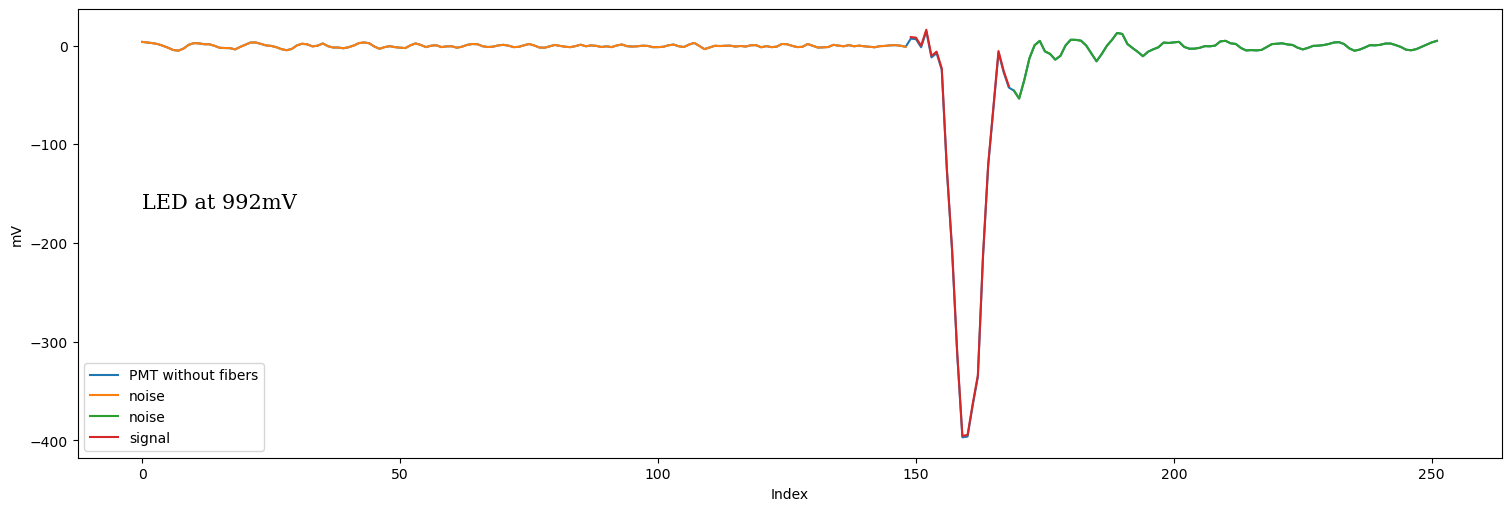

In [11]:
fig, ax = plt.subplots(1, 1, figsize = (15, 5), constrained_layout=True)

frame = 246

base = []

#______inicio de bucle on frames HERE_______
#________________________________________________BASELINE_______________________________________________________

wave = waveform[frame*n_points: (frame + 1)*n_points].copy()
x_ax = wave[:, 0]

ax.plot(x_ax, wave[:, ch], label = detect[ch] + fibers[fib])

t0 = t1 + int(np.where(wave[:, ch][t1 : t2] == wave[:, ch][t1 : t2].min())[0][0])

pre_base = wave[:, ch][:t0 - dt_izq]
x_ax_pre = x_ax[:t0 - dt_izq]

post_base = wave[:, ch][t0 + dt_dch:]
x_ax_post = x_ax[t0 + dt_dch:]

base.append(pre_base.mean())
base.append(post_base.mean())

ax.plot(x_ax_pre, pre_base, label = 'noise')
ax.plot(x_ax_post, post_base, label = 'noise')

baseline = np.array(base).mean()
print('base = ', base)
print('baseline = ', baseline)

wave[:, ch] = wave[:, ch] - baseline # NOW THE WAVEFORM IS CORRECTED
# ax.plot(x_ax, wave[:, ch], label = detect[ch] + ' corrected by baseline')



#________________________________________________INTEGRAL_______________________________________________________


peak_integr = []
peak_integr_pos = []

dt_izq = 10
dt_dch = 10

peak = wave[:, ch][t0 - dt_izq : t0 + dt_dch].copy()
x_ax_peak = x_ax[t0 - dt_izq : t0 + dt_dch].copy()

integr = np.trapz(peak, x=x_ax_peak)
#     integr = np.trapz(data_region, x=x_ax_reg)

peak_integr.append(integr)
peak_integr_pos.append([integr, frame])

peak_integr = np.array(peak_integr)
peak_integr_pos = np.array(peak_integr_pos)

ax.plot(x_ax_peak, peak, label='signal')
# ax.legend(loc = 'best')

peak_integr.mean()
# peak_integr
# peak_integr_pos

#_____________________________________plot settings______________________________________________________________

ax.set_ylabel('mV')
ax.set_xlabel('Index')
# ax.set_title('LED pulse at 1.47V, 2us, 5%df')
ax.text(0., -150., 'LED at 992mV', #transform=ax.transAxes,
            fontsize=15, verticalalignment='top', fontfamily='serif',
            bbox=dict(facecolor='1.', edgecolor='none', pad=3.0))
ax.legend(loc = 'best')

### ALL frames

In [12]:
len(waveform)

2897244

In [13]:
# fig, ax = plt.subplots(1, 1, figsize = (15, 5), constrained_layout=True)

base = []
peak_integr = []
peak_integr_pos = []

#______inicio de bucle on frames HERE_______

for frame in range(n_frames):
    #________________________________________________BASELINE_______________________________________________________

    wave = waveform[frame*n_points: (frame + 1)*n_points].copy()
    x_ax = wave[:, 0]


    t0 = t1 + int(np.where(wave[:, ch][t1 : t2] == wave[:, ch][t1 : t2].min())[0][0])

    pre_base = wave[:, ch][:t0 - dt_izq]
    x_ax_pre = x_ax[:t0 - dt_izq]

    post_base = wave[:, ch][t0 + dt_dch:]
    x_ax_post = x_ax[t0 + dt_dch:]

    base.append(pre_base.mean())
    base.append(post_base.mean())

    baseline = np.array(base).mean()
#     print(base, baseline)

    wave[:, ch] = wave[:, ch] - baseline # NOW THE WAVEFORM IS CORRECTED



    #________________________________________________INTEGRAL_______________________________________________________

    
# #     integrate around the peak
#     peak = wave[:, ch][t0 - dt_izq : t0 + dt_dch]
#     x_ax_peak = x_ax[t0 - dt_izq : t0 + dt_dch]
#     integr_method = 'integrate around the peak'
    
# #     integrate in a fixed window t1-t2
#     peak = wave[:, ch][t1 : t2]
#     x_ax_peak = x_ax[t1 : t2]
#     integr_method = 'integrate in a fixed window t1-t2'  

#     integrate ALL waveform
    peak = wave[:, ch]
    x_ax_peak = x_ax
    integr_method = 'integrate ALL waveform'


    integr = np.trapz(peak, x=x_ax_peak)
    #     integr = np.trapz(data_region, x=x_ax_reg)

    peak_integr.append(integr)
    peak_integr_pos.append([integr, frame])
    
#     print(frame)

peak_integr = np.array(peak_integr)
peak_integr_pos = np.array(peak_integr_pos)

# peak_integr.mean()
# peak_integr
# peak_integr_pos

#_____________________________________plot settings______________________________________________________________

# ax.plot(x_ax, waveform[frame], label = 'calib PMT')
# ax.plot(x_ax_pre, pre_base, label = 'PMT noise')
# ax.plot(x_ax_post, post_base, label = 'PMT noise')
# ax.plot(x_ax, wave, label = 'Leire\'s PMT corrected by baseline')
# ax.plot(x_ax_peak, peak, label='signal')

# ax.set_ylabel('mV')
# ax.set_xlabel('Index')
# ax.set_title('LED pulse at 1.47V, 2us, 5%df')
# ax.text(0.05, .1, 'LED at 992mV, frame %s'%(frame), 
#         transform=ax.transAxes, # to use (x,y) pos with relative values to the axis and not absolute data points
#         fontsize=15, verticalalignment='top', fontfamily='serif',
#         bbox=dict(facecolor='1.', edgecolor='none', pad=3.0))
# ax.legend(loc = 'best')

In [14]:
wave[:, ch][t1 : t2]
# waveform[:, ch]

array([ 1.15935546e+01, -2.47521539e+00,  1.17461546e+01,  1.76678961e+00,
       -1.39500454e+01, -6.38152539e+00, -9.04892454e+01, -1.76854945e+02,
       -2.72345945e+02, -3.68203945e+02, -3.99758945e+02, -3.73177945e+02,
       -3.51112945e+02, -2.56140945e+02, -1.38890945e+02, -8.17000454e+01,
       -1.86497454e+01, -1.15390454e+01, -4.25454454e+01, -4.15688454e+01,
       -5.48136454e+01, -4.11721454e+01, -1.60557454e+01, -2.68884539e+00,
        8.93852461e+00, -3.37753881e-02, -8.54830539e+00, -1.27292454e+01,
       -1.16306454e+01, -2.93298539e+00,  5.94776461e+00,  7.74832461e+00,
        6.46656461e+00,  3.78098461e+00, -4.06215539e+00, -1.18442454e+01,
       -8.12105539e+00,  2.43818461e+00,  1.79730761e+00,  1.05559846e+01,
        1.58966546e+01,  4.26926461e+00,  5.46067612e-01, -2.68884539e+00,
       -1.03183454e+01, -6.47308539e+00, -3.69594539e+00,  4.23995612e-01,
        2.31611361e+00,  3.44528461e+00])

In [15]:
len(peak_integr)

11497

## Integrals distribution

In [16]:
# Fitting distributions to define

# note: pdf are normilized to 1 so we have yo add an amplitude param
def gauss(x, a,  mu, sigma):
    return a*stats.norm.pdf(x, mu, sigma) 

def gauss_sum(x, a0,  mu0, sigma0, a1, mu1, sigma1):
    return a0*stats.norm.pdf(x, mu0, sigma0)  + a1*stats.norm.pdf(x, mu1, sigma1)

n_pe = 2

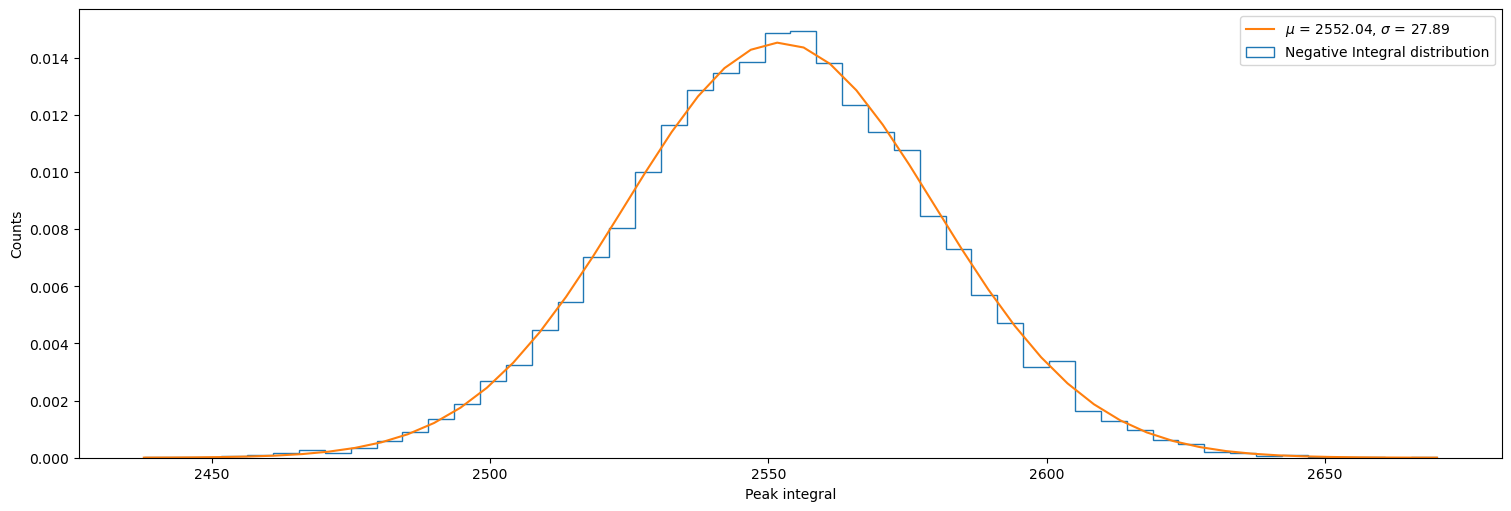

In [17]:
fig, ax = plt.subplots(1, 1, figsize = (15, 5), constrained_layout=True)

# events, bins, bars = plt.hist(peak_integr, 50, density=False, range=(-750, -550), label='Integral distribution')
events, bins, bars = plt.hist(-peak_integr, 50, density=True, label='Negative Integral distribution', 
                              histtype='step')
x_ax = np.linspace(bins.min(), bins.max(), len(bins)-1)

# # sum of gaussians fit
# popt, pcov = scipy.optimize.curve_fit(gauss_sum, x_ax, events, bounds=([0, -1, 1, 0, -1, 1], 
#                                                                        [np.inf, 1e2, 1e2, np.inf, 1e2, 1e2])) 
# a = np.zeros(n_pe); mu = np.zeros(n_pe); sigma = np.zeros(n_pe)

# a[0], mu[0], sigma[0], a[1], mu[1], sigma[1] = popt
# best_fit_line = gauss_sum(x_ax, a[0], mu[0], sigma[0], a[1], mu[1], sigma[1])

# gaussian fit
# popt, pcov = scipy.optimize.curve_fit(gauss, x_ax, events, bounds=([0, 0, 1], [np.inf, 3e3, 1e2])) 
# popt, pcov = scipy.optimize.curve_fit(gauss, x_ax, events, p0=[1, 500, 1e2]) 
popt, pcov = scipy.optimize.curve_fit(gauss, x_ax, events, p0=[1, 2750, 1e2]) 
a, mu, sigma = popt
best_fit_line = gauss(x_ax, a, mu, sigma)

# ax.plot(x_ax, best_fit_line, label='Sum of gaussian fit')
# ax.plot(x_ax, gauss(x_ax, a[0], mu[0], sigma[0]), '-', label='$\mu$ = %.2f, $\sigma$ = %.2f'%(mu[0], sigma[0]))
# ax.plot(x_ax, gauss(x_ax, a[1], mu[1], sigma[1]), '-y', label='$\mu$ = %.2f, $\sigma$ = %.2f'%(mu[1], sigma[1]))
ax.plot(x_ax, gauss(x_ax, a, mu, sigma), '-', label='$\mu$ = %.2f, $\sigma$ = %.2f'%(mu, sigma))

ax.set_ylabel('Counts')
ax.set_xlabel('Peak integral')
ax.legend(fontsize=10, loc='best')

In [19]:
print(detect[ch] + fibers[fib])
print('Integration method:', integr_method)
print('Amplification = ', a)
print('Mean value = ', mu)
print('Std = ', sigma)

PMT without fibers
Integration method: integrate ALL waveform
Amplification =  1.0159876012738698
Mean value =  2552.042903789487
Std =  27.885723802276548
